# Feature Extraction and Time Series Forecasting

The purpose of this notebook is to demonstrate the use of feature extraction and selection in kdb+/q as a tool for forecasting the future behaviour of a system. In this case, we are using information about the historical behaviour of a stock with the goal of predicting the actual value of the stocks close price the next day.

As is demonstrated in the results section of this notebook, this should **not** be used as a method for stock prediction and is shown here as a use-case to demonstrate the versatility of the algorithm, its use outside of classification and ability to deal with historical data.

---

## Loading library scripts and data

In the following cell, the kdb+/q machine learning toolkit (ML-Toolkit) is loaded in to allow the use of functions provided in both the FRESH and Utilities sections of the library, including the FRESH algorithm.

The chosen dataset is loaded below and contains the daily Open/Low/High/Close interest prices and Volume of trades for Amazon Stock from 1997-2017.

In [1]:
\c 15 100
\l ../../ml.q
.ml.loadfile`:init.q
\l graphics.q

/ turn off any python warnings
warn:.p.import[`warnings];
warn[`:filterwarnings]["ignore"];

In [2]:
5#amzndaydata:{lower[cols x]xcol x}("DFFFFJJ";enlist ",")0:`:SampleDatasets/amzn_day.us.txt
-1!"This dataset contains stock information for ",(string count amzndaydata)," days."
5#amzndaydata:.ml.dropconstant[amzndaydata]  / drop columns without variance 

date       open high low  close volume   openint
------------------------------------------------
1997.05.16 1.97 1.98 1.71 1.73  14700000 0      
1997.05.19 1.76 1.77 1.62 1.71  6106800  0      
1997.05.20 1.73 1.75 1.64 1.64  5467200  0      
1997.05.21 1.64 1.65 1.38 1.43  18853200 0      
1997.05.22 1.44 1.45 1.31 1.4   11776800 0      


"This dataset contains stock information for 5170 days."


date       open high low  close volume  
----------------------------------------
1997.05.16 1.97 1.98 1.71 1.73  14700000
1997.05.19 1.76 1.77 1.62 1.71  6106800 
1997.05.20 1.73 1.75 1.64 1.64  5467200 
1997.05.21 1.64 1.65 1.38 1.43  18853200
1997.05.22 1.44 1.45 1.31 1.4   11776800


---

## Set target values for forecasting

In this case, we are attempting to use rolled table forecasting frames to predict the close price for the next day given extracted features from the previous 10 days. To generate the targets, the first 10 days were omitted as these, the rolled table frames in this case, would be incomplete and as such may skew our results.

In [3]:
tabletargets:10 _amzndaydata
targets:tabletargets[`close]
count targets

5160


---

## Preprocessing

Below we produce polynomial features from our data in order to allow for interactions between terms in the system. This allows us to study both combined and individual features.

The date column is removed from the data it is not be required given the data will be subject to a sliding window which negates its significance as a column.

In [4]:
/ add 2nd order polynomial features to the table 
table:amzndaydata^.ml.polytab[flip 1_flip amzndaydata;2]

/ remove the date column from the data
5#table:(1_cols t)#t:table 

open high low  close volume   open_high open_low open_close open_volume  high_low high_close high..
-------------------------------------------------------------------------------------------------..
1.97 1.98 1.71 1.73  14700000 3.9006    3.3687   3.4081     2.8959e+07   3.3858   3.4254     2.91..
1.76 1.77 1.62 1.71  6106800  3.1152    2.8512   3.0096     1.074797e+07 2.8674   3.0267     1.08..
1.73 1.75 1.64 1.64  5467200  3.0275    2.8372   2.8372     9458256      2.87     2.87       9567..
1.64 1.65 1.38 1.43  18853200 2.706     2.2632   2.3452     3.091925e+07 2.277    2.3595     3.11..
1.44 1.45 1.31 1.4   11776800 2.088     1.8864   2.016      1.695859e+07 1.8995   2.03       1.70..


---

## Produce a rolling table forecasting frame

The following function creates a rolling window, with window lengths `n`, on the data and implements feature extraction on each window. Caution should be exercised when applying this to large datasets as the number of calculations required will be:

```q
(1+count table)-n
```

In [5]:
rollcreatefeatures:{[x;fns;n] 
 raze{.ml.fresh.createfeatures[x;`placer;(-1)_cols x;y]}[;fns]each
 {update placer:last y from x y}[x;]each dropswin[n;til count x]}
dropswin:{(-1) _ (x-1) _ swin[x;y]}
swin:{[w;s]{1_x,y}\[w#0;s]}

---

## Feature Extraction

Below the parameter table has been updated such that we only apply functions without parameters to the dataset. This is achieved by setting rows of the parameter table to invalid for `pnum>0`.

In [6]:
ptab:.ml.fresh.params

/ make all hyperparameter features invalid
ptab:update valid:0b from ptab where pnum>0

/ do not produce aggregatted fast fourier transform, this can be computationally expensive
show ptab:update valid:0b from ptab where f=`fftaggreg

f             | pnum pnames pvals valid
--------------| -----------------------
absenergy     | 0                 1    
abssumchange  | 0                 1    
aggautocorr   | 0                 1    
augfuller     | 0                 1    
count         | 0                 1    
countabovemean| 0                 1    
countbelowmean| 0                 1    
fftaggreg     | 0                 0    
firstmax      | 0                 1    
firstmin      | 0                 1    
..


The following cell produces features extracted by applying a 10 day sliding windows to the data. These features are used in the prediction of the following days close price. 

The keyed column in the output table gives the column number of the last value in each window. 

All incomplete windows have been removed from the application of the sliding window and the window for the last day is not created as this could not be used in the prediction of a target.

In [7]:
show tabraw:rollcreatefeatures[table;ptab;10]
-1"The forecasting frame contains ",(string count tabraw)," datapoints.";

placer| open_absenergy open_abssumchange open_count open_countabovemean open_countbelowmean open_..
------| -----------------------------------------------------------------------------------------..
9     | 26.2488        0.89              10         5                   5                   0    ..
10    | 24.648         0.69              10         4                   6                   0    ..
11    | 23.8913        0.68              10         3                   7                   0    ..
12    | 23.0888        0.64              10         4                   6                   0    ..
13    | 22.4156        0.5               10         6                   4                   0.3  ..
14    | 22.6524        0.57              10         6                   4                   0.2  ..
15    | 23.4199        0.61              10         4                   6                   0.9  ..
16    | 24.0639        0.55              10         3                   7                   0.9  ..


---

## Feature significance  

Below is an example of how the k-best features can be determined through significant tests. In the given example k is set to 200.

In [8]:
show tabreduced:key[tabraw]!(.ml.fresh.significantfeatures[p;targets;.ml.fresh.ksigfeat 200])#p:value tabraw
-1 "The number of columns in the initial dataset is: ",string count cols amzndaydata;
-1 "The number of columns in the unfiltered dataset is: ",string count cols tabraw;
-1 "The number of columns in the filtered dataset is: ",string count cols tabreduced;

placer| open_absenergy open_abssumchange open_max open_mean open_meanabschange open_med open_min ..
------| -----------------------------------------------------------------------------------------..
9     | 26.2488        0.89              1.97     1.612     0.09888889         1.58     1.41     ..
10    | 24.648         0.69              1.76     1.566     0.07666667         1.525    1.41     ..
11    | 23.8913        0.68              1.73     1.543     0.07555556         1.52     1.41     ..
12    | 23.0888        0.64              1.64     1.518     0.07111111         1.51     1.41     ..
13    | 22.4156        0.5               1.62     1.496     0.05555556         1.505    1.41     ..
14    | 22.6524        0.57              1.62     1.504     0.06333333         1.51     1.41     ..
15    | 23.4199        0.61              1.66     1.529     0.06777778         1.515    1.42     ..
16    | 24.0639        0.55              1.71     1.549     0.06111111         1.525    1.42     ..


---

## Prepare data for model

The data must now be converted from a table to a matrix in order to be passed to a machine learning algorithm for training.

In the below cell, we reintroduce the original data for each day into the dataset. This allows the final dataset to contain both the original and derived datapoints.

In [9]:
mattab:{flip value flip x}
rawdata:-1 _9 _amzndaydata
fitvalsfilter:0^mattab[rawdata,'value tabreduced]
fitvalsraw:0^mattab[rawdata,'value tabraw]
newpredictor:0^mattab[delete date from rawdata]

Data must be split into training and testing sets before being passed to them model. Below we use 0.2% as the size of the data in the testing set. In the below example:

* `dict1` = dictionary with the initial time-series data
* `dict2` = dictionary with the unfiltered data
* `dict3` = dictionary with the filtered data

In [10]:
dict1:.ml.traintestsplit[newpredictor;targets;.2];
dict2:.ml.traintestsplit[fitvalsraw;targets;.2];
dict3:.ml.traintestsplit[fitvalsfilter;targets;.2];

---

## Training the Model

Here we train our model using a Gradient Boosting Regressor to estimate the close price. The application of regression on financial data can be quite temperamental, with a high dependency the data split which influences the final result.

The addition of ``` `verbose pykw 1 ``` in the definition of the model allows for the time required for the training of the classifier and the associated training loss to be displayed if desired.

In [11]:
k:rand 1000
reg:.p.import[`sklearn.ensemble][`:GradientBoostingRegressor][`learning_rate pykw 0.1;`n_estimators pykw 200;`random_state pykw k]

Once initialized, we can fit data to the model and then use the trained model to make predictions.

In [12]:
/ inital data
reg[`:fit][dict1[`xtrain];dict1[`ytrain]]`;
pred1:reg[`:predict][dict1[`xtest]]`

/ unfiltered data
reg[`:fit][dict2[`xtrain];dict2[`ytrain]]`;
pred2:reg[`:predict][dict2[`xtest]]`

/ filtered data
reg[`:fit][dict3[`xtrain];dict3[`ytrain]]`;
pred3:reg[`:predict][dict3[`xtest]]`

---

## Results

Below the mean squared error and R2-score are calculated between the actual and predicted values of the next day close price. These are reasonable proxies for the accuracy of the model. We will compare results with the benchmark which states that todays close price is the best indicator of what tomorrows close will be.

In [13]:
-1"The mean square error(mse) between the test and prediction from the untreated data is: ",string .ml.mse[dict1[`ytest];pred1];
-1"The mse between the test and predicted data without filtering is: ",string .ml.mse[dict2[`ytest];pred2];
-1"The mse between the test and predicted data with filtering is: ",string .ml.mse[dict3[`ytest];pred3];
-1"The mse between the current and previous day would be: ",string .ml.mse . 1 -1_\:amzndaydata[`close];

The mean square error(mse) between the test and prediction from the untreated data is: 38.9195
The mse between the test and predicted data without filtering is: 31.26743
The mse between the test and predicted data with filtering is: 29.35548
The mse between the current and previous day would be: 28.48191


In [14]:
-1"The r2score between the test and prediction from the untreated data is: ",string .ml.r2score[dict1[`ytest];pred1];
-1"The r2score between the test and predicted data without filtering is: ",string .ml.r2score[dict2[`ytest];pred2];
-1"The r2score between the test and predicted data with filtering is: ",string .ml.r2score[dict3[`ytest];pred3];
-1"The r2score between the current and previous day would be: ",string .ml.r2score . 1 -1_\:amzndaydata[`close];

The r2score between the test and prediction from the untreated data is: 0.9993291
The r2score between the test and predicted data without filtering is: 0.9994997
The r2score between the test and predicted data with filtering is: 0.9995218
The r2score between the current and previous day would be: 0.9995275


We can also compare the true and predicated values for the next days close price using a line graph, shown below.

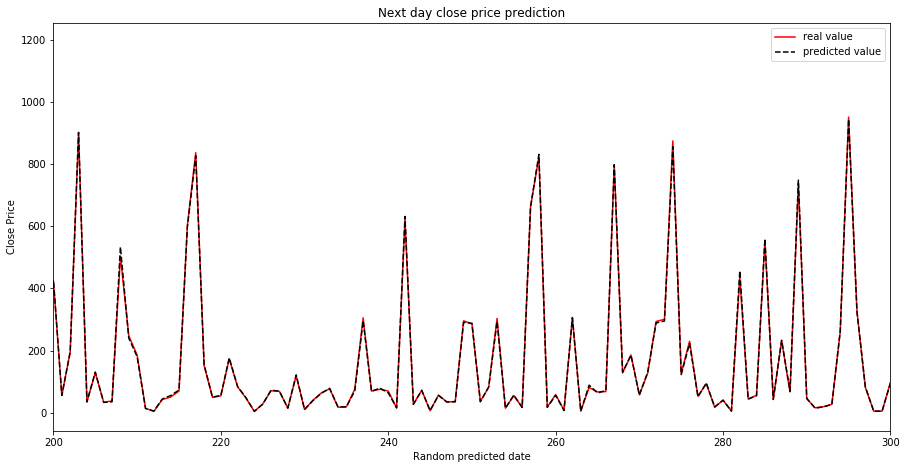

In [15]:
.ml.plotprxpred[dict2[`ytest];pred2]

---

## Conclusions

Multiple runs of the above fit and results sections give an indication both of the usefulness of this form of analysis and the difficultly which is posed in the prediction of stock information. 

In the majority of cases it is seen that the mean squared error decreases in the order:

1. Untreated Data
2. Extracted Features without significance testing
3. Extracted Features with significance testing
4. Yesterday's price = Today's price

Large variations in the mean squared error can occur depending on how the data is split by the `.ml.traintestsplit` function. This is related to the inclusion/omission of specific events which would cause large errors in prediction, such as issues with the global economy or issues with staff. It can also have a detrimental effect on the order seen above with variations in this order possible if the features extracted from the split data are not truely indicative of the behaviour of the system.

---